# Test Sampling Without Replacement

Do the algorithms work? Are they non-biased? and how fast are they?

Algorithms:
  * Reservoir algorithm R
  * Reservoir algorithm L
  * Fisher Yates
  * Hidden shuffle 
     


In [89]:
import gfort2py as gf
import os
import numpy as np
import matplotlib.pyplot as plt

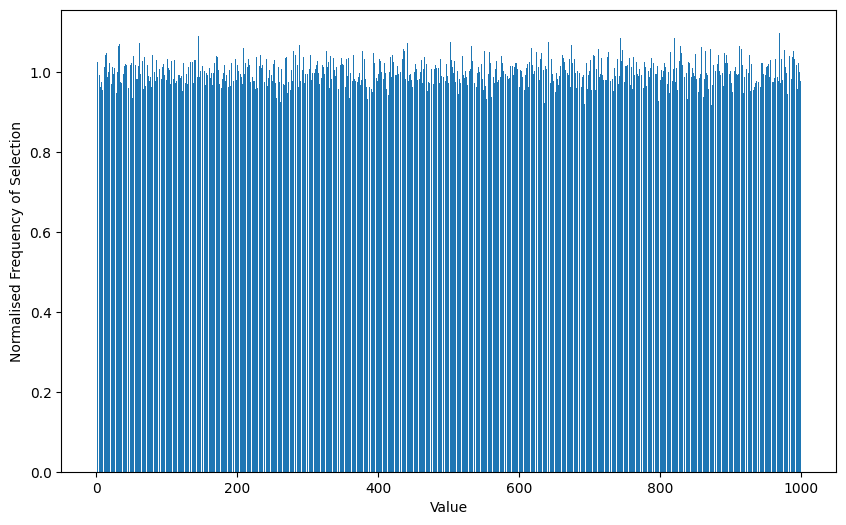

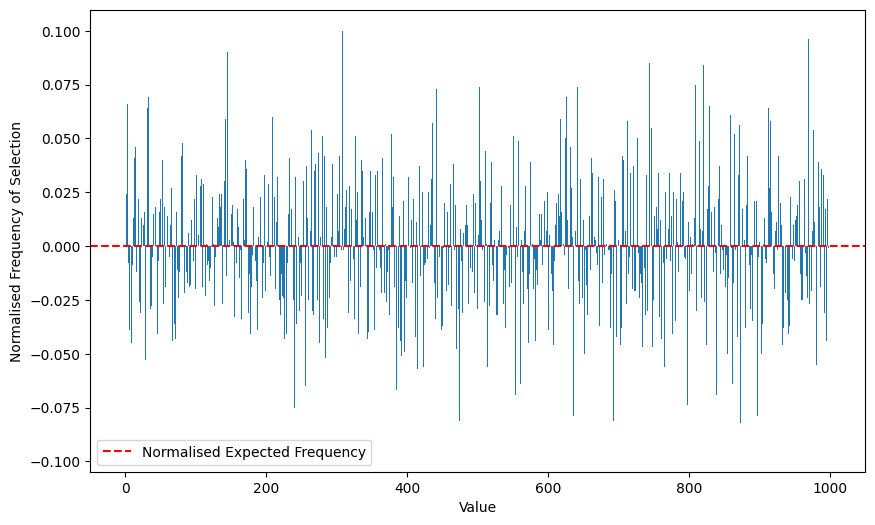

Top 10 values that deviate from the expected normalised value of 1.0:
307 0.998
969 0.9560000000000001
406 1.012
416 1.0
144 0.986
822 0.974
961 0.975
743 0.99
820 1.0110000000000001
872 1.056


In [90]:
""" Simple Reservoir Sampling

Routine is implemented to sample from [1, n_range], therefore we ignore the first element, 0, when processing
results in python (rather than doing a i - 1 mapping)
"""
reservoir_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')

m_samples = 100
n_range = 1000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = reservoir_m.reservoir_sampling(m_samples, n_range, np.empty(shape=(m_samples)), seed=seeds)
    # Fill counts
    for j in result.args['selected']:
        occurrences[j] += 1

# Uniform probability of getting each value
uniform_p = m_samples / n_range
normalize =  1. / (n_repeat * uniform_p)

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_range + 1), occurrences[1:] * normalize)
plt.xlabel('Value')
plt.ylabel('Normalised Frequency of Selection')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_range + 1), (occurrences[1:] * normalize) - 1)
plt.xlabel('Value')
plt.axhline(y=0.0, color='r', linestyle='--', label=f'Normalised Expected Frequency') 
plt.legend()
plt.ylabel('Normalised Frequency of Selection')
plt.show()

print("Top 10 values that deviate from the expected normalised value of 1.0:")
indices = np.argsort(np.abs((occurrences[1:] * normalize) - 1))

for i in indices[-10:][::-1]:
    print(i, occurrences[i] * normalize)


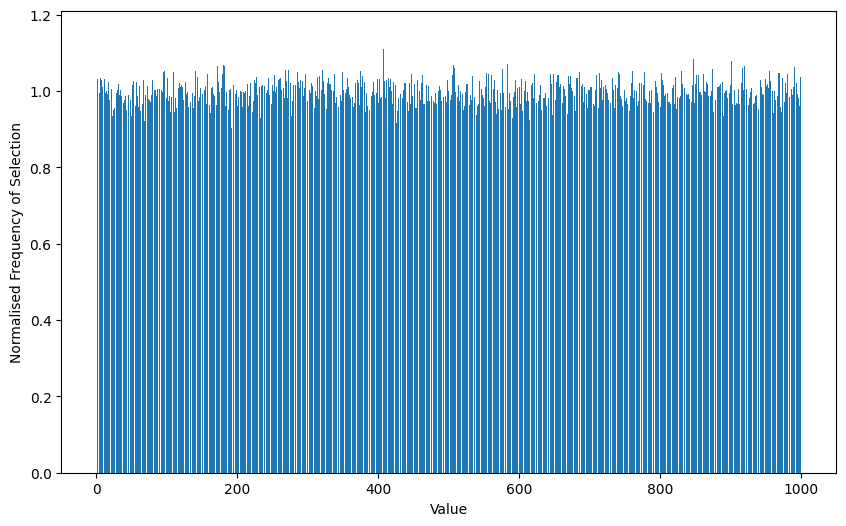

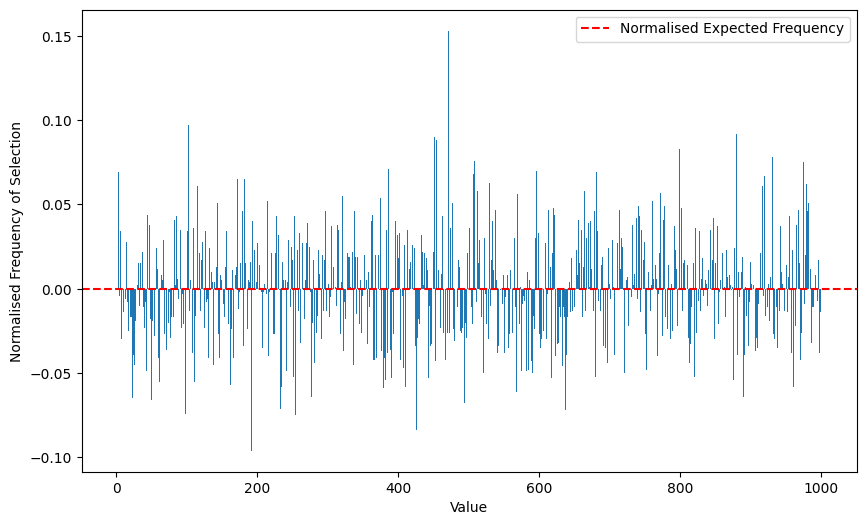

Top 10 values that deviate from the expected normalised value of 1.0:
470 0.974
407 0.9530000000000001
101 1.034
191 1.0050000000000001
535 1.0110000000000001
879 0.978
450 1.022
453 0.9570000000000001
847 1.042
425 1.0170000000000001


In [91]:
""" Reservoir Sampling using Algorithm L.

Routine is implemented to sample from [1, n_range], therefore we ignore the first element, 0, when processing
results in python (rather than doing a i - 1 mapping)
"""
reservoir_m = gf.fFort('../cmake-build/libfortran_rand.dylib', '../cmake-build/modules/reservoir_sampling_m.mod')

m_samples = 100
n_range = 1000
n_repeat = 10000
occurrences = np.zeros(shape=n_range+1)

for i in range(0, n_repeat):
    seeds = np.random.randint(0, 2**64, size=8, dtype=np.uint64)
    result = reservoir_m.reservoir_sampling_algorithml(m_samples, n_range, seeds, np.empty(shape=(m_samples)))
    # Fill counts
    for j in result.args['reservoir']:
        occurrences[j] += 1

# Uniform probability of getting each value
uniform_p = m_samples / n_range
normalize =  1. / (n_repeat * uniform_p)

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_range + 1), occurrences[1:] * normalize)
plt.xlabel('Value')
plt.ylabel('Normalised Frequency of Selection')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_range + 1), (occurrences[1:] * normalize) - 1)
plt.xlabel('Value')
plt.axhline(y=0.0, color='r', linestyle='--', label=f'Normalised Expected Frequency') 
plt.legend()
plt.ylabel('Normalised Frequency of Selection')
plt.show()

print("Top 10 values that deviate from the expected normalised value of 1.0:")
indices = np.argsort(np.abs((occurrences[1:] * normalize) - 1))

for i in indices[-10:][::-1]:
    print(i, occurrences[i] * normalize)


In [ ]:
""" Fisher-Yates Shuffle
"""

In [ ]:
"""Hidden Shuffle
"""